# Customer Sentiment Naive Bayes Classifier

Classifier to predict whether a customer review is positive, negative, or neutral.

Requirements:

    * sckikit-learn
    * imbalanced-learn
    * pandas
    * Numpy
    * nltk

In [77]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [78]:
pip install --upgrade imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [33]:
import numpy as np
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
reviews = pd.read_csv('iphone.csv')
reviews.head()

,productAsin,country,date,isVerified,ratingScore,reviewTitle,reviewDescription,reviewUrl,reviewedIn,variant,variantAsin
0,B09G9BL5CP,India,11-08-2024,True,4,No charger,"Every thing is good about iPhones, there's not...",https://www.amazon.in/gp/customer-reviews/R345...,Reviewed in India on 11 August 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
1,B09G9BL5CP,India,16-08-2024,True,5,iPhone 13 256GB,"It look so fabulous, I am android user switche...",https://www.amazon.in/gp/customer-reviews/R2HJ...,Reviewed in India on 16 August 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
2,B09G9BL5CP,India,14-05-2024,True,4,Flip camera option nill,I tried to flip camera while recording but no ...,https://www.amazon.in/gp/customer-reviews/R3Y7...,Reviewed in India on 14 May 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
3,B09G9BL5CP,India,24-06-2024,True,5,Product,100% genuine,https://www.amazon.in/gp/customer-reviews/R1P9...,Reviewed in India on 24 June 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
4,B09G9BL5CP,India,18-05-2024,True,5,Good product,Happy to get the iPhone 13 in Amazon offer,https://www.amazon.in/gp/customer-reviews/R1XI...,Reviewed in India on 18 May 2024,Colour: MidnightSize: 256 GB,B09G9BQS98


The following cleans and prepares the data:

In [35]:
column_name_mapping = {'productAsin':'Product_Number','country':'Country','date':'Date',
                       'isVerified':'Verified','ratingScore':'Rating_Score','reviewTitle':'Review_Title',
                       'reviewDescription':'Review_Description','reviewUrl':'Review_Url',
                       'reviewedIn':'Reviewer_Location','variant':'Product_Type','variantAsin':'Product_Type_Number'}

reviews.rename(columns=column_name_mapping, inplace=True)

In [36]:
emojis = (r'[\U0001F600-\U0001F64F' 
        r'\U0001F300-\U0001F5FF'  
        r'\U0001F680-\U0001F6FF'  
        r'\U0001F700-\U0001F77F'  
        r'\U0001F780-\U0001F7FF'  
        r'\U0001F800-\U0001F8FF'  
        r'\U0001F900-\U0001F9FF'  
        r'\U0001FA00-\U0001FA6F'  
        r'\U0001FA70-\U0001FAFF'  
        r'\U00002764\ufe0f'  
        r']+')

# Removes emoji characters from Review_Description column
reviews['Review_Description'] = reviews['Review_Description'].apply(lambda x: re.sub(emojis, '', str(x)) if isinstance(x, str) else x)

# Asigns rating score a category of High, Low, and Neutral
reviews['Rating_Category'] = np.where(reviews['Rating_Score'] >= 4, 'High', np.where(reviews['Rating_Score'] <=2, 'Low', 'Neutral'))

In [37]:
# Asigns rating category a number
rating_mapping = {'High':1,'Low':2,'Neutral':3}
reviews['Numerical_Rating_Category'] = reviews['Rating_Category'].map(rating_mapping)

In [38]:
reviews.head()

,Product_Number,Country,Date,Verified,Rating_Score,Review_Title,Review_Description,Review_Url,Reviewer_Location,Product_Type,Product_Type_Number,Rating_Category,Numerical_Rating_Category
0,B09G9BL5CP,India,11-08-2024,True,4,No charger,"Every thing is good about iPhones, there's not...",https://www.amazon.in/gp/customer-reviews/R345...,Reviewed in India on 11 August 2024,Colour: MidnightSize: 256 GB,B09G9BQS98,High,1
1,B09G9BL5CP,India,16-08-2024,True,5,iPhone 13 256GB,"It look so fabulous, I am android user switche...",https://www.amazon.in/gp/customer-reviews/R2HJ...,Reviewed in India on 16 August 2024,Colour: MidnightSize: 256 GB,B09G9BQS98,High,1
2,B09G9BL5CP,India,14-05-2024,True,4,Flip camera option nill,I tried to flip camera while recording but no ...,https://www.amazon.in/gp/customer-reviews/R3Y7...,Reviewed in India on 14 May 2024,Colour: MidnightSize: 256 GB,B09G9BQS98,High,1
3,B09G9BL5CP,India,24-06-2024,True,5,Product,100% genuine,https://www.amazon.in/gp/customer-reviews/R1P9...,Reviewed in India on 24 June 2024,Colour: MidnightSize: 256 GB,B09G9BQS98,High,1
4,B09G9BL5CP,India,18-05-2024,True,5,Good product,Happy to get the iPhone 13 in Amazon offer,https://www.amazon.in/gp/customer-reviews/R1XI...,Reviewed in India on 18 May 2024,Colour: MidnightSize: 256 GB,B09G9BQS98,High,1


In [39]:
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1,2))

reviews = reviews.dropna(subset=['Review_Description']) # Remove rows with missing values in Review_Description

X = vectorizer.fit_transform(reviews['Review_Description'])

y = reviews['Numerical_Rating_Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

In [40]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `Ba

In [42]:
print(f"Cross-validation scores: {cv_scores}")
print(f"Average cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.73860911 0.72422062 0.70983213 0.70673077 0.69711538]
Average cross-validation score: 0.7153016048699501


The distribution of positive, negative, and neutral reviews:

In [43]:
num_reviews = len(reviews)
num_positive = len(reviews[reviews['Numerical_Rating_Category']==1])
num_negative = len(reviews[reviews['Numerical_Rating_Category']==2])
num_neutral = len(reviews[reviews['Numerical_Rating_Category']==3])

print("Number of reviews:",num_reviews)
print("Number of positive reviews:", num_positive)
print("Number of negative reviews:", num_negative)
print("Number of neutral reviews:", num_neutral)
print()

print("Probability of positive review:", num_positive/num_reviews)
print("Probability negative review:", num_negative/num_reviews)
print("Probability of neutral review:", num_neutral/num_reviews)

Number of reviews: 2976
Number of positive reviews: 1994
Number of negative reviews: 747
Number of neutral reviews: 235

Probability of positive review: 0.6700268817204301
Probability negative review: 0.25100806451612906
Probability of neutral review: 0.07896505376344086


The following trains the model:

In [44]:
model = make_pipeline(SMOTE(sampling_strategy='auto', random_state=42),  # SMOTE oversampling
    MultinomialNB(class_prior=[0.33,0.33,0.34])  # Classifier
)

In [45]:
print(f'Average accuracy: {cv_scores.mean():.2f}')

Average accuracy: 0.72


In [46]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.90      0.81      0.85       602
           2       0.76      0.68      0.72       222
           3       0.24      0.52      0.32        69

    accuracy                           0.76       893
   macro avg       0.63      0.67      0.63       893
weighted avg       0.82      0.76      0.78       893



/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Prediction:

In [47]:
def predict_customer_sentiment(review_text):
    review_tfidf = vectorizer.transform([review_text])
    
    sentiment_labels = {1:'Positive', 2:'Negative', 3:'Neutral'}
    
    sentiment = model.predict(review_tfidf.reshape(1,-1))
    
    sentiment = sentiment[0]
    
    return sentiment_labels[sentiment]

Testing:

In [49]:
testreview1 = "I absolutely love my new iPhone!"

In [50]:
print(predict_customer_sentiment(testreview1))

Positive


In [51]:
testreview2 = "I am extremely disappointed with the iPhone. The battery life is bad."

In [52]:
print(predict_customer_sentiment(testreview2))

Neutral


In [53]:
testreview3 = "The phone is ok."

In [54]:
predict_customer_sentiment(testreview3)

'Negative'

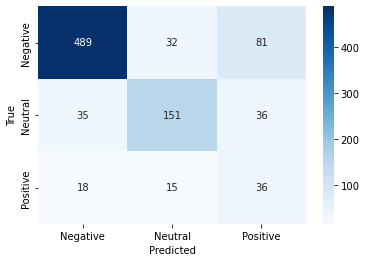

In [56]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()